#  
**Due date: 11:59 pm EST on Dec. 1, 2022 (Thu.)**

In this semester, we will use Google Colab for the assignments, which allows us to utilize resources that some of us might not have in their local machines such as GPUs. You will need to use your Stony Brook (*.stonybrook.edu) account for coding and Google Drive to save your results.

## Google Colab Tutorial
---
Go to https://colab.research.google.com/notebooks/, you will see a tutorial named "Welcome to Colaboratory" file, where you can learn the basics of using google colab.

## Enable Colab GPU Acceleration
---
Navigation menu: **Runtime->Change runtime type->Hardware accelerator->GPU**

## Local Machine Prerequisites
---
Since we are using Google Colab, all the code is run on the server environment where lots of libraries or packages have already been installed. In case of missing 
 libraries or if you want to install them in your local machine, below are the links for installation.
* **Install Python 3.6.9**: https://www.python.org/downloads/ or use Anaconda (a Python distribution) at https://docs.continuum.io/anaconda/install/. Below are some materials and tutorials which you may find useful for learning Python if you are new to Python.
  - https://docs.python.org/3.6/tutorial/index.html
  - https://www.learnpython.org/
  - https://docs.opencv.org/4.1.2/d6/d00/tutorial_py_root.html
  - http://www.scipy-lectures.org/advanced/image_processing/index.html


* **Install Python packages**: install Python packages: `numpy`, `matplotlib`, `opencv-python` using pip, for example:
```
pip install numpy matplotlib opencv-python
``` 
	Note that when using “pip install”, make sure that the version you are using is python3. Below are some commands to check which python version it uses in you machine. You can pick one to execute:
  
```
    pip show pip
    pip --version
    pip -V
```

In case of the wrong version, use `pip3` for python3 explictly.

* **Install Jupyter Notebook**: follow the instructions at http://jupyter.org/install.html to install Jupyter Notebook and familiarize yourself  with it. *After you have installed Python and Jupyter Notebook, please open this notebook file with your Jupyter Notebook and do your homework there.*


## Description
---
In this homework, we will implement an image-to-image translation method, based on
[pix2pix](https://phillipi.github.io/pix2pix/). To be more specific,  we'll built from scratch a GAN which can translate abstract labels into facade images. 

Before we start, please read the [pix2pix paper](https://arxiv.org/pdf/1611.07004.pdf) first and understand how pix2pix works.

There are 6 parts + 1 bonus part in this homework with a total of 110 points including 10 bonus points. Be sure to read **Submission Guidelines** below. They are important.

**Do not upload** the data subfolder or trained models before submitting on blackboard due to the size limit.


## Some Tutorials (PyTorch)
---
- You will be using PyTorch for deep learning toolbox (follow the [link](http://pytorch.org) for installation).
- For PyTorch beginners, please read this [tutorial](http://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html) before doing your homework.
- Feel free to study more tutorials at http://pytorch.org/tutorials/.
- Find cool visualization here at http://playground.tensorflow.org.

In [ ]:
# Mount your google drive where you've saved your assignment folder
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# Replace '------' with the path such that "Surname_Givenname_SBUID_hw*" is your working directory
%cd '/content/gdrive/My Drive/Panda_Jyotiprakash_115235582_hw5'

/content/gdrive/My Drive/Panda_Jyotiprakash_115235582_hw5


### Part 1 Load dataset
---

We'll train a model to generate pictures of facades from label maps, using the [CMP Facade
Database](http://cmp.felk.cvut.cz/~tylecr1/facade/) . This dataset contains 606 rectified images of facades from various sources, which have been manually annotated.

**{10 points}** For the training process, we will use a batch size equal to `1`, as in the original paper. During testing, we will process `4` images in a single batch, so that we can visualize
several results at once.

Load the training set and test set under the folder `./facades`. Normalize the images to $[-1, 1]$. For each set, return a batch list. Show one image from the training set and its label side by side in a `1x2` grid.

# New Section

In [ ]:
# download the dataset
! chmod +x ./download_dataset.sh
! ./download_dataset.sh

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import glob
import random 
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [ ]:
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import numpy as np

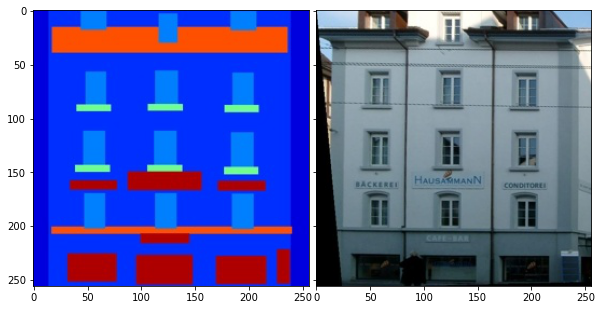

In [ ]:
def set_seeds(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def load_dataset(path, shuffle=False):
    # load the images under the folder
    # remember to normalize them to [-1, 1]
    image_names = [name for name in glob.glob(path + '/*.jpg')]
    data = []
    ##########--WRITE YOUR CODE HERE--##########
    for i in range(len(image_names)):
      image = Image.open(image_names[i])

      image_tensor = transforms.functional.to_tensor(image)
      # image_tensor /= 255.0
      # print(torch.max(image_tensor))
      image_tensor = image_tensor * 2 - 1
      image_width = image_tensor.shape[2]
      input_image = image_tensor[:, :, : image_width // 2]
      input_image.to(device)
      input_image=input_image.reshape(1,input_image.shape[0],input_image.shape[1],input_image.shape[2])
      target_image = image_tensor[:, :, image_width // 2 :]
      target_image.to(device)
      target_image=target_image.reshape(1,target_image.shape[0],target_image.shape[1],target_image.shape[2])
      tup=(target_image,input_image)
      data.append(tup)

      
    ##########-------END OF CODE-------##########
    # return a list of tuples.
    # for each tuple, the first element is ground truth, the second one is label image
    # both images should be tensors
    return data


set_seeds(302)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train = load_dataset('./facades/train', shuffle=True)
test = load_dataset('./facades/test')

def show_img_pair(s_left, s_right):
    # convert the pixels back to [0, 1] when visualizing
    
    ##########--WRITE YOUR CODE HERE--##########
    s_left = (s_left + 1.0)/2.0
    s_right = (s_right + 1.0)/2.0
    im1=s_left.permute(1, 2, 0).numpy()
    im2=s_right.permute(1, 2, 0).numpy()

    fig = plt.figure(figsize=(10., 10.))
    grid = ImageGrid(fig, 111, nrows_ncols=(1, 2), axes_pad=0.1, )

    for ax, im in zip(grid, [im1, im2]):
        ax.imshow(im)

    plt.show()    
        
    ##########-------END OF CODE-------##########    
    
    
idx = 150
show_img_pair(train[idx][0][0], train[idx][1][0])

### Part 2 Models
---
In this part, we will define the network based on the architectures from the paper.
Please check the Appendix of the paper for the details of this architecture.

Let $Ck$ denote a Convolution-BatchNorm-ReLU layer with k filters. $CDk$
denotes a Convolution-BatchNormDropout-ReLU layer with a dropout rate of 50%. All
convolutions are 4 x 4 spatial filters applied with stride 2. Convolutions in the encoder,
and in the discriminator, downsample the input by a factor of 2, whereas in the decoder
they upsample the input by a factor of 2.

#### **{15 points}** (a) Generator
The U-Net encoder-decoder architecture consists of:

U-Net encoder:
$$C64-C128-C256-C512-C512-C512-C512-C512$$

U-Net decoder:

$$CD512-CD1024-CD1024-C1024-C1024-C512-C256-C128$$

After the last layer in the decoder, a convolution is applied to map to the number
of output channels, which is `3` in our problem, followed by a `tanh` function. As a
special case, batch normalization is not applied to the first $C64$ layer in the encoder.
All ReLUs in the encoder are leaky, with slope `0.2`, while ReLUs in the decoder are
not leaky.
If you are not familiar with the architecture of UNet, please check [this paper](https://arxiv.org/abs/1505.04597) first.

#### **{15 points}** (b) Discriminator

The discriminator architecture is:
$$C64-C128-C256-C512$$
After the last layer, a convolution is applied to map to a 1-dimensional output,
followed by a sigmoid function. As an exception to the above notation, batch
normalization is not applied to the first $C64$ layer. All ReLUs are leaky, with slope
`0.2`.

Hint: Use `torch.nn.functional.leaky_relu` for leaky ReLU.

In [ ]:
class DownSampleConv(nn.Module):

    def __init__(self, 
                 in_channels, 
                 out_channels, 
                 kernel=4, 
                 strides=2, 
                 padding=1, 
                 activation=True, 
                 batchnorm=True
    ):
        
        super().__init__()
        self.activation = activation
        self.batchnorm = batchnorm

        self.conv = nn.Conv2d(in_channels, out_channels, kernel, strides, padding)

        if batchnorm:
            self.bn = nn.BatchNorm2d(out_channels)

        if activation:
            self.act = nn.LeakyReLU(0.2)

    def forward(self, x):
        x = self.conv(x)
        if self.batchnorm:
            x = self.bn(x)
        if self.activation:
            x = self.act(x)
        return x

In [ ]:
class UpSampleConv(nn.Module):

    def __init__(
        self,
        in_channels,
        out_channels,
        kernel=4,
        strides=2,
        padding=1,
        activation=True,
        batchnorm=True,
        dropout=False
    ):
        super().__init__()
        self.activation = activation
        self.batchnorm = batchnorm
        self.dropout = dropout

        self.deconv = nn.ConvTranspose2d(in_channels, out_channels, kernel, strides, padding)

        if batchnorm:
            self.bn = nn.BatchNorm2d(out_channels)

        if activation:
            self.act = nn.ReLU(True)

        if dropout:
            self.drop = nn.Dropout2d(0.5)

    def forward(self, x):
        x = self.deconv(x)
        if self.batchnorm:
            x = self.bn(x)

        if self.dropout:
            x = self.drop(x)
        return x

In [ ]:
# discriminator
class Discriminator(nn.Module):
    def __init__(self, n_channels):
        # n_channels means num of input channels
        super(Discriminator, self).__init__()
        ##########--WRITE YOUR CODE HERE--##########
        self.d1 = DownSampleConv(6, 64, batchnorm=False)
        self.d2 = DownSampleConv(64, 128)
        self.d3 = DownSampleConv(128, 256)
        self.d4 = DownSampleConv(256, 512)
        self.final = nn.Conv2d(512, 1, kernel_size=1)
        self.activ = nn.Sigmoid()
        ##########-------END OF CODE-------##########
        
    def forward(self, x,y):
        ##########--WRITE YOUR CODE HERE--##########
        x = torch.cat([x, y], axis=1)
        x0 = self.d1(x)
        x1 = self.d2(x0)
        x2 = self.d3(x1)
        x3 = self.d4(x2)
        x4 = self.final(x3)
        x_d=self.activ(x4)

        
        ##########-------END OF CODE-------##########
        return x_d


##########--WRITE YOUR CODE HERE--##########    
netD = Discriminator(3).to(device)
# feel free to do some sanity check here
#img_D=netD(train[idx][0],)
##########-------END OF CODE-------##########    

In [ ]:
#Generator
class GeneratorUNet(nn.Module):
    def __init__(self, n_channels):
        super(GeneratorUNet, self).__init__()
        ##########--WRITE YOUR CODE HERE--##########
        #𝐶64−𝐶128−𝐶256−𝐶512−𝐶512−𝐶512−𝐶512−𝐶512
        self.encoders = [
            DownSampleConv(n_channels, 64, batchnorm=False),  # bs x 64 x 128 x 128
            DownSampleConv(64, 128),  # bs x 128 x 64 x 64
            DownSampleConv(128, 256),  # bs x 256 x 32 x 32
            DownSampleConv(256, 512),  # bs x 512 x 16 x 16
            DownSampleConv(512, 512),  # bs x 512 x 8 x 8
            DownSampleConv(512, 512),  # bs x 512 x 4 x 4
            DownSampleConv(512, 512),  # bs x 512 x 2 x 2
            DownSampleConv(512, 512, batchnorm=False),  # bs x 512 x 1 x 1
        ]
        #𝐶𝐷512−𝐶𝐷1024−𝐶𝐷1024−𝐶1024−𝐶1024−𝐶512−𝐶256−𝐶128
        self.decoders = [
            UpSampleConv(512, 512, dropout=True),  # bs x 512 x 2 x 2
            UpSampleConv(1024, 512, dropout=True),  # bs x 512 x 4 x 4
            UpSampleConv(1024, 512, dropout=True),  # bs x 512 x 8 x 8
            UpSampleConv(1024, 512),  # bs x 512 x 16 x 16
            UpSampleConv(1024, 256),  # bs x 256 x 32 x 32
            UpSampleConv(512, 128),  # bs x 128 x 64 x 64
            UpSampleConv(256, 64),  # bs x 64 x 128 x 128
        ]

        self.decoder_channels = [512, 512, 512, 512, 256, 128, 64]
        self.final_conv = nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1)
        self.tanh = nn.Tanh()

        self.encoders = nn.ModuleList(self.encoders)
        self.decoders = nn.ModuleList(self.decoders)
        
        ##########-------END OF CODE-------##########
    
    def forward(self, x):   
        ##########--WRITE YOUR CODE HERE--##########
        skips_cons = []
        for encoder in self.encoders:
            x = encoder(x)

            skips_cons.append(x)

        skips_cons = list(reversed(skips_cons[:-1]))
        decoders = self.decoders[:-1]

        for decoder, skip in zip(decoders, skips_cons):
            x = decoder(x)
            # print(x.shape, skip.shape)
            x = torch.cat((x, skip), axis=1)

        x = self.decoders[-1](x)
        # print(x.shape)
        x = self.final_conv(x)
        x_g = self.tanh(x)

        
        ##########-------END OF CODE-------##########
        return x_g
    
##########--WRITE YOUR CODE HERE--##########    
netG = GeneratorUNet(3).to(device)

netGL1 = GeneratorUNet(3).to(device)
# feel free to do some sanity check here
#img_G=netG(train[150][0])
##########-------END OF CODE-------##########  

### Part 3 Optimizor
---
**{5 points}** For optimization, we'll use the Adam optimizer, with a learning rate of `0.0002`, and momentum parameters  $\beta_1= 0.5$; $\beta_2 = 0.999$.

In [ ]:
# Define the optimizors here, make sure you give them the right parameters

##########--WRITE YOUR CODE HERE--########## 
optim_G1 = torch.optim.Adam(netG.parameters(), lr=0.0002,betas=(0.5, 0.999))
optim_G2 = torch.optim.Adam(netGL1.parameters(), lr=0.0002,betas=(0.5, 0.999))
optim_D = torch.optim.Adam(netD.parameters(), lr=0.0002,betas=(0.5, 0.999))
##########-------END OF CODE-------##########

### Part 4 Training
---
**{20 points}** For each batch, first train discriminator D by using the average loss of real image and fake image. Then train generator G by using the following loss equation.
$$G^*=\arg \min_{G} \max_{D} L_{cGAN}(G, D) + \lambda L_{L1}(G) $$

In this homework, you will train two different models: one using only the L1 loss, the other using the equation above with $\lambda = 100$. 

As a sanity check, please compare your results with those in the paper (e.g. Figure 4) to make sure they roughly match.

Train the network for at least 20 epochs (at least 10 epochs for the model with only L1 loss,) but you are encouraged to train longer to obtain better results. (In the paper, they train
for 200 epochs.) Save your models to `pix2pix.pth` and `pix2pixL1.pth` using the given code. 

Note: Training training each epoch should take less than 2 minutes if you are using Colab. **Remember to save your models regularly** so you won't lose your progress accidentally.

**{5 points}** In the end, plot the Generator/Discriminator (G/D) loss history (averaged per epoch) of the two models with respect to the epoch in two plots. i.e. the first plot should contain the G/D loss of the model with L1 and cGAN, the second plot should contain the L1 loss of the other model.


### Generator with L1 and cGAN loss function



In [ ]:
torch.backends.cudnn.benchmark = True
Gen_loss = []
Dis_loss = []
Gen_loss_ = []
Dis_loss_ = []

In [ ]:
from tqdm import tqdm

def train1_G(netG, netD, train_dl, OptimizerG, OptimizerD, L1_Loss, BCE_Loss):
    for idx, (x,y) in enumerate(train_dl):
        x = x.cuda()
        y = y.cuda()
        ############## Train Discriminator ##############
        fakeY = netG(x)
        Dis_real = netD(x,y)
        Dis_real_loss = BCE_Loss(Dis_real, torch.ones_like(Dis_real))
        Dis_fake = netD(x,fakeY.detach())
        Dis_fake_loss = BCE_Loss(Dis_fake, torch.zeros_like(Dis_fake))
        Disc_loss = (Dis_real_loss + Dis_fake_loss)/2
        #print(D_loss)

        netD.zero_grad()
        Dis_loss.append(Disc_loss.item())
        Dis_loss_.append(Disc_loss.item())
        Disc_loss.backward()
        OptimizerD.step()
        
        ############## Train Generator ##############
        Dis_fake = netD(x, fakeY)
        Gen_fake_loss = BCE_Loss(Dis_fake, torch.ones_like(Dis_fake))
        L1 = L1_Loss(fakeY,y) * 100
        Genc_loss = Gen_fake_loss + L1
        #print(G_loss)

        OptimizerG.zero_grad()
        Gen_loss.append(Genc_loss.item())
        Gen_loss_.append(Genc_loss.item())
        Genc_loss.backward()
        OptimizerG.step()
        
        

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

netG = netG.to(device)
netD = netD.to(device)

##########--WRITE YOUR CODE HERE--########## 

BCE = nn.BCEWithLogitsLoss()
L1= nn.L1Loss()
    
#used 200 epochs
for epoch in range(20):
  train1_G(
      netG, netD, train, optim_G1, optim_D, L1, BCE
    )
  print(epoch)
  print(sum(Gen_loss) / len(Gen_loss))
  print(sum(Dis_loss) / len(Dis_loss))
  Gen_loss.clear()
  Dis_loss.clear()
##########-------END OF CODE-------##########

0
11.344544763565063
0.5039026202261447
1
11.330940219163894
0.5044078443944454
2
11.280269994735718
0.5032898546755313
3
11.319427063465119
0.5036547812819481
4
11.283504725694657
0.5033060702681541
5
11.244479278326034
0.5033008368313312
6
11.19054670214653
0.5032547479867935
7
11.181688446998596
0.5032631534337998
8
11.191729422807693
0.5034196701645851
9
11.126814435720444
0.5032649356126785
10
11.087586439847946
0.5032055921852588
11
11.089937176704407
0.5032054935395718
12
11.074505379199982
0.5032055331766605
13
11.030709657669068
0.5032054236531258
14
11.061705520153046
0.5032055108249187
15
11.012306954860687
0.5032056398689747
16
10.95254135131836
0.5032052811980248
17
10.979387922286987
0.5032052932679654
18
10.927105038166046
0.5032455684244632
19
10.924280277490617
0.5034456127882003


### Generator with L1 loss function


In [ ]:
torch.backends.cudnn.benchmark = True
Gen_lossL1 = []
Dis_lossL1 = []
Gen_loss_L1 = []
Dis_loss_L1 = []

In [ ]:
from tqdm import tqdm

def train1_G(netG, netD, train_dl, OptimizerG, OptimizerD, L1_Loss, BCE_Loss):
    for idx_, (x_,y_) in enumerate(train_dl):
        x = x_.cuda()
        y = y_.cuda()
        ############## Train Discriminator ##############
        y_fake = netG(x)
        D_real = netD(x,y)
        D_real_loss = BCE_Loss(D_real, torch.ones_like(D_real))
        D_fake = netD(x,y_fake.detach())
        D_fake_loss = BCE_Loss(D_fake, torch.zeros_like(D_fake))
        D_loss = (D_real_loss + D_fake_loss)/2
        #print(D_loss)

        netD.zero_grad()
        Dis_lossL1.append(D_loss.item())
        Dis_loss_L1.append(D_loss.item())
        D_loss.backward()
        OptimizerD.step()
        
        ############## Train Generator ##############
        D_fake = netD(x, y_fake)
        L1 = L1_Loss(y_fake,y)
        G_loss = L1
        #print(G_loss)

        OptimizerG.zero_grad()
        Gen_lossL1.append(G_loss.item())
        Gen_loss_L1.append(G_loss.item())
        G_loss.backward()
        OptimizerG.step()
        
        

In [ ]:

##########--WRITE YOUR CODE HERE--########## 
BCE_Loss = nn.BCEWithLogitsLoss()
L1_Loss = nn.L1Loss()
    
#i used 20 epochs
for epoch_l1 in range(20):
  train1_G(
      netGL1, netD, train, optim_G2, optim_D, L1_Loss, BCE_Loss
    )
  print(epoch_l1)
  print(sum(Gen_lossL1) / len(Gen_lossL1))
  print(sum(Dis_lossL1) / len(Dis_lossL1))
  Gen_lossL1.clear()
  Dis_lossL1.clear()

##########-------END OF CODE-------##########

0
0.20711252012370546
0.5032065429805238
1
0.20467502158135176
0.5032056276500225
2
0.2028287861123681
0.5032053688168525
3
0.2009277955815196
0.503205224275589
4
0.19912878807634116
0.5032052165269851
5
0.19759109284728765
0.5032050928473473
6
0.19565823767334223
0.503204954713583
7
0.19430481616407633
0.5032048830389977
8
0.19226704571396114
0.5032048249244689
9
0.19062185432761908
0.5032047809660435
10
0.1901142018660903
0.5032047590613365
11
0.1884124356508255
0.5032047037780285
12
0.18654671486467123
0.5032046779990196
13
0.18519703958183528
0.5032046653330327
14
0.1838200281560421
0.5032046136260032
15
0.18218098051846027
0.5032046394050121
16
0.18070084001868963
0.5032045850157738
17
0.17970958814024926
0.5032045762240887
18
0.17864692516624928
0.5032045540213584
19
0.17742566786706448
0.5032045593857766


### Saving the Model


In [ ]:
# codes for saving models, feel free to change them triallll

torch.save({
    'G': netG.state_dict(),
    'D': netD.state_dict(),
    'epoch': epoch,    
    }, 'pix2pix__.pth')



In [ ]:
# codes for saving models, feel free to change them

torch.save({
    'G': netG.state_dict(),
    'D': netD.state_dict(),
    'epoch': epoch,    
    }, 'pix2pix.pth')



In [ ]:
torch.save({
    'G': netGL1.state_dict(),
    'D': netD.state_dict(),
    'epoch': epoch_l1,    
    }, 'pix2pixL1.pth')

In [ ]:
# codes for restoring models, feel free to change them

path = "pix2pix.pth"
checkpoint = torch.load(path)
netG.load_state_dict(checkpoint['G'])
netD.load_state_dict(checkpoint['D'])
epoch = checkpoint['epoch']
loss_iter = checkpoint['loss']

path = "pix2pixL1.pth"
checkpoint = torch.load(path)
netGL1.load_state_dict(checkpoint['G'])
epoch_l1 = checkpoint['epoch']
loss_iter_l1 = checkpoint['loss']


### Generator with L1 and cGAN loss function


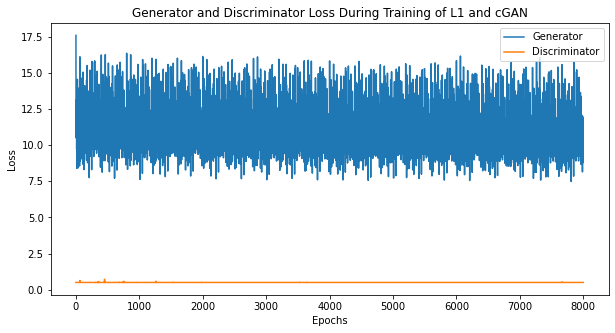

In [ ]:
# Plot the loss

##########--WRITE YOUR CODE HERE--##########
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training of L1 and cGAN")
plt.plot(Gen_loss_,label="Generator")
plt.plot(Dis_loss_,label="Discriminator")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

##########-------END OF CODE-------##########

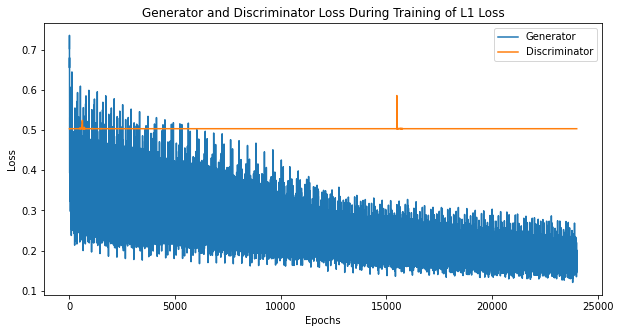

In [ ]:
# Plot the loss

##########--WRITE YOUR CODE HERE--##########
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training of L1 Loss")
plt.plot(Gen_loss_L1,label="Generator")
plt.plot(Dis_loss_L1,label="Discriminator")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

##########-------END OF CODE-------##########

### Part 5 Evaluation
---

Compared to a classification problem, evaluating an image translation model could be tricky because we don't always have the ground-truth available. There are several different ways to compare the performance of different GAN models:

1. Visualize the generated images of different GAN models. 

2. Compute a distance, such as **Frechet Inception Distance** (**FID**, the smaller the better, [paper](https://arxiv.org/abs/1706.08500)), between the generated images and the real images, or compute the Inception Score (**IS**, the higher the better, [paper](https://arxiv.org/pdf/1606.03498.pdf)) for the generated images. We strongly encourage you to read these papers.

3. Using generated images for downstream tasks, such as classification, segmentation, etc. and computing the task accuracy.

Now it's your turn to evaluate the models you trained. 

**{5 points}** We'll first visualize `4` test samples and plot them as in Figure 4 in the pix2pix paper, to get some qualitative results. You can select any interesting samples from the **test set**.

**{5 points}** Then let's do some quantitative analysis. Adapt this **Inception Score** ([ref](https://github.com/sbarratt/inception-score-pytorch/blob/master/inception_score.py)) implementation, and report the mean score of each model on the test set. Again, you are encouraged to train your models longer.

In [ ]:
modelA = GeneratorUNet(3)
modelA.to(device)
checkpoint = torch.load('pix2pix.pth')
modelA.load_state_dict(checkpoint['G'])

modelB = GeneratorUNet(3)
modelB.to(device)
checkpoint = torch.load('pix2pixL1.pth')
modelB.load_state_dict(checkpoint['G'])

<All keys matched successfully>

<ipython-input-44-39b283341725>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img_G=modelA(torch.tensor(test[i][0]).to(device))
<ipython-input-44-39b283341725>:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img_G=modelB(torch.tensor(test[i][0]).to(device))


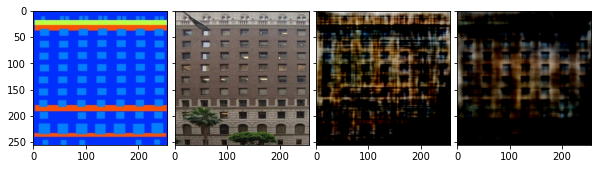

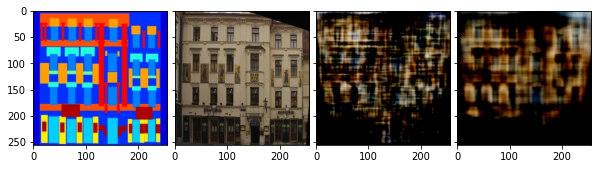

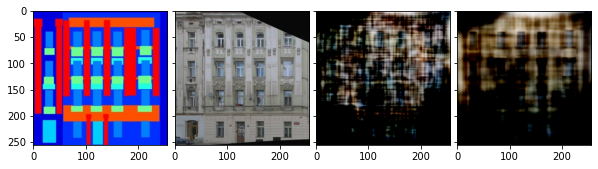

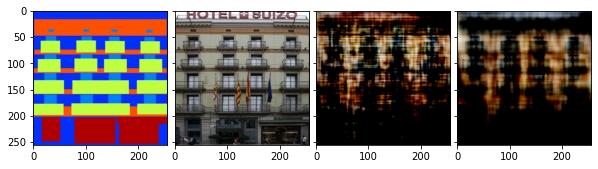

In [ ]:
# Visualization
# Please read Figure 4 in the pix2pix paper first

##########--WRITE YOUR CODE HERE--##########

for idx,i in enumerate([90,7,40,45]):
  s_left = test[i][0][0]
  s_right = test[i][1][0]
  s_left = (s_left + 1.0)/2.0
  s_right = (s_right + 1.0)/2.0
  im1=s_left.permute(1, 2, 0).numpy()
  im2=s_right.permute(1, 2, 0).numpy()

  train_=test.copy()
  img_G=modelA(torch.tensor(test[i][0]).to(device))
  img_G.to(device)
  img_G1=img_G[0].permute(1, 2, 0)
  im3=(img_G1.detach().cpu().numpy())


  img_G=modelB(torch.tensor(test[i][0]).to(device))
  img_G.to(device)
  img_G1=img_G[0].permute(1, 2, 0)
  im4=(img_G1.detach().cpu().numpy())

  fig = plt.figure(figsize=(10., 20.))
  grid = ImageGrid(fig, 111, nrows_ncols=(1, 4), axes_pad=0.1, )

  for ax, im in zip(grid, [im1, im2, im3, im4]):
      ax.imshow(im)

  plt.show()    

##########-------END OF CODE-------##########

In [ ]:
import torchvision.transforms as transforms

transform=transforms.Compose([
                                
                                 transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                             ])
test_pred__=[]
test_pred_l1__=[]
n=len(test)
for i in range(n):
  img_G=modelA(torch.tensor(test[i][0]).to(device))
  img_G.to(device)
  img_G = transform(img_G)
  im4=(test_pred__[0][0].detach().cpu().numpy())
  im4=im4.transpose(1, 2, 0)
  test_pred__.append(im4)
  img_GL=modelB(torch.tensor(test[i][0]).to(device))
  img_GL.to(device)
  img_GL = transform(img_GL)
  test_pred_l1__.append(img_GL)

im4=(test_pred__[0][0].detach().cpu().numpy())
im4=im4.transpose(1, 2, 0)
plt.imshow(im4)

In [ ]:
# Inception Scores
from torchvision.models.inception import inception_v3
from scipy.stats import entropy

dtype = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor
inception_model = inception_v3(pretrained=True, transform_input=False).type(dtype)
inception_model.eval();
up = nn.Upsample(size=(299, 299), mode='bilinear', align_corners=True).type(dtype)

def inception_score(images, splits=10):
    ##########--WRITE YOUR CODE HERE--##########
    N = len(images)
    split_scores = []
    preds = np.zeros((N, 1000))
    for k in range(splits):
        part = preds[k * (N // splits): (k+1) * (N // splits), :]
        py = np.mean(part, axis=0)
        scores = []
        for i in range(part.shape[0]):
            pyx = part[i, :]
            scores.append(entropy(pyx, py))
        split_scores.append(np.exp(np.mean(scores)))

    
    ##########-------END OF CODE-------##########
    return np.mean(split_scores)


# Get the translation on test set
##########--WRITE YOUR CODE HERE--##########

test_pred = test_pred__
test_pred_l1 = test_pred_l1__
##########-------END OF CODE-------##########

inception_s = inception_score(test_pred)
inception_s_l1 = inception_score(test_pred_l1)
print("IS for different losses, evaluated on facades dataset")
from IPython.display import HTML, display
import tabulate
table = [["Loss","IS ↑"],
         ["L1", f"{inception_s_l1:.4f}"],
         ["L1 + cGAN", f"{inception_s:.4f}"]]
display(HTML(tabulate.tabulate(table, tablefmt='html', headers="firstrow")))

IS for different losses, evaluated on facades dataset


Loss,IS ↑
L1,nan
L1 + cGAN,nan


### Part 6 Understanding pix2pix
---
#### {5 points}Problem 1  
What image sizes can Pix2pix train with, and why can it handle different image sizes?

Hint: Explain this based on the generator and discriminator architectures.<br>
**Image of any size can train with Pix2Pix as the parameter in generator and discriminator does not depent on the image size . It only depends on the number of channels in the input image.**

#### {5 points}Problem 2 

Given an input image with size $256\times256\times6$ for the discriminator, write down the size of each neuron's receptive field after each layer, using the **discriminator** network architectures above:

\begin{align*}
r_{l-1} &= s_l r_l + (k_l - s_l) \\
&= 2 r_l + 2
\end{align*}

\begin{align*}
r_4 = 4 * 4 * 6 = 96
\end{align*}

e.g. $$Input → C64 → 782 → C128 →390 → C256 → 194 → C512 → 96


**Make sure you calculate the receptive field, not the size of the image.**

#### {5 points}Problem 3
Explain why minimizing only the L1 loss results in a blurry image.<br>

**Since the L1 loss gives the L1 distance between between original image and generated image , in case of blurry image the L1 distance is quite low so it is not that effective in training.**
#### {5 points}Problem 4
Why do we use PatchGAN in Pix2pix? <br>
**PatchGAN uses smaller patches of  NxN size in the generated image to discriminate it from real or fake instead of discriminating the entire image at once.Pix2Pix has an additional loss specifically for the generator so that it can generate images closer to the ground truth.**

Answer:

### {10 points} Bonus: Spectral Normalization

Spectral normalization (**SN**, [paper](https://arxiv.org/abs/1802.05957)) is a simple and useful technique for stabilizing GAN training. Replace `batch normalization` with `spectral normalization` in both discriminator and generator, train the new model with the same L1 and cGAN loss for at least 20 epochs, then save the model to `pix2pixSN.pth`. Finally, perform the same evaluation you did in part 5 and compare the performance of all the models you trained.

Hint: use `torch.nn.utils.spectral_norm`.


## Submission guidelines
---
We will grade your homework based on your submitted notebook file. We will check the notebook for both results and code. Please make sure you run your code and print out the results in the notebook before submitting (we expect to see the results before running your code by ourselves.)

You submit your homework by first creating a ***google shared link*** of a folder for your homework (described below), and put that link into the ***text submission section*** of your homework submission on Blackboard. ([How to submit your link?](https://drive.google.com/file/d/16-FlPSiu5n-pRezLfcbAvgYxXtGtrs16))

To generate the ***google shared link***, first create a folder named ***Surname_Givenname_SBUID_hw**** in your Google Drive with your CS account (or your SBU account if you don't have a CS account). The structure of the files in the folder should be exactly the same as the one you downloaded. For instance in this homework:

```
Surname_Givenname_SBUID_hw5
        |---CSE527-22F-HW5.ipynb
```
Note that this folder should be in your Google Drive with your account.

Then right click this folder, click ***Get shareable link***, in the People textfield, enter the TAs' email: ***haoyuwu@cs.stonybrook.edu*** and ***vhnguyen@cs.stonybrook.edu***. Make sure that the TAs who have the link **can edit**, ***not just*** **can view**, and also **uncheck** the **Notify people** box. ([How to share link?](https://drive.google.com/file/d/17R6j6yE8_8vXioOB3nNvbEPzxcI-rr_H) )

***IMPORTANT: Please do not make any modification to the folder and its files after the submission deadline***. (All modifications can be seen by the TAs via the revision history.) Note that in google colab, we will only grade the version of the code right before the timestamp of the submission made in blackboard.

The input and output paths are predefined and **DO NOT** change them, (we assume that 'Surname_Givenname_SBUID_hw1' is your working directory, and all the paths are relative to this directory).  The image read and write functions are already written for you. All you need to do is to fill in the blanks as indicated to generate proper outputs.


-- DO NOT change the folder structure, please just fill in the blanks. <br>

You are encouraged to post and answer questions on Piazza. Based on the amount of email that we have received in past years, there might be delays in replying to personal emails. Please ask questions on Piazza and send emails only for personal issues.

If you alter the folder structures, the grading of your homework will be significantly delayed and possibly penalized.

Be aware that your code will undergo plagiarism check both vertically and horizontally. Please do your own work.

Late submission penalty: <br>
There will be a 10% penalty per day for late submission. However, you will have 4 days throughout the whole semester to submit late without penalty. Note that the grace period is calculated by days instead of hours. If you submit the homework one minute after the deadline, one late day will be counted. Likewise, if you submit one minute after the deadline, the 10% penaly will be imposed if not using the grace period.
